### Imports

In [1]:
import modin.pandas as md
import statsmodels as sm
import os
from tabulate import tabulate
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
import sys
sys.path.append('../library')

import itertools

from midStats import *
from core import *
from plotting import *

colorPalette = loadPalette()

### Load Data

In [2]:
df = md.read_csv(os.path.join('../data/', 'tmdbDetails.csv'))
df.drop_duplicates(inplace=True, keep='last')

2024-09-05 15:43:00,398	INFO worker.py:1781 -- Started a local Ray instance.
Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


### Global Vars

In [3]:
colsOfInterest = ['runtime', 'revenue', 'budget']
plotWidth = 600
plotHeight = 600
saveImagePath = '../assets/savedImages/boxOfficeAndRuntime'

if not os.path.exists(saveImagePath):
    os.makedirs(saveImagePath)

### Remove Outliers & Missing Data

In [4]:
df = df[df['budget'] > 0]
df = df[df['revenue'] > 0]
df = df[df['runtime'] > 70]

In [5]:
numCols = df.select_dtypes(include = ['number']).columns

for col in colsOfInterest:
    df[col] = dropNumericalOutliers(x = df[col], low = .01, high = .99)

df.dropna(subset=colsOfInterest, how='any', inplace=True)

### Describe Data

In [6]:
df[colsOfInterest].describe()

,runtime,revenue,budget
count,25360.000000,2.536000e+04,2.536000e+04
mean,108.266759,5.112668e+07,2.059863e+07
std,19.483563,9.341703e+07,2.809192e+07
min,76.000000,1.000000e+02,1.280000e+02
25%,94.000000,2.440285e+06,2.800000e+06
50%,104.000000,1.340195e+07,1.000000e+07
75%,118.000000,5.265959e+07,2.500000e+07
max,183.000000,7.350991e+08,1.760000e+08


#### Show Distributions


Bad key acatter.alpha in file ../assets/plot_styles.mplstyle, line 48 ('acatter.alpha: .5')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.9.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


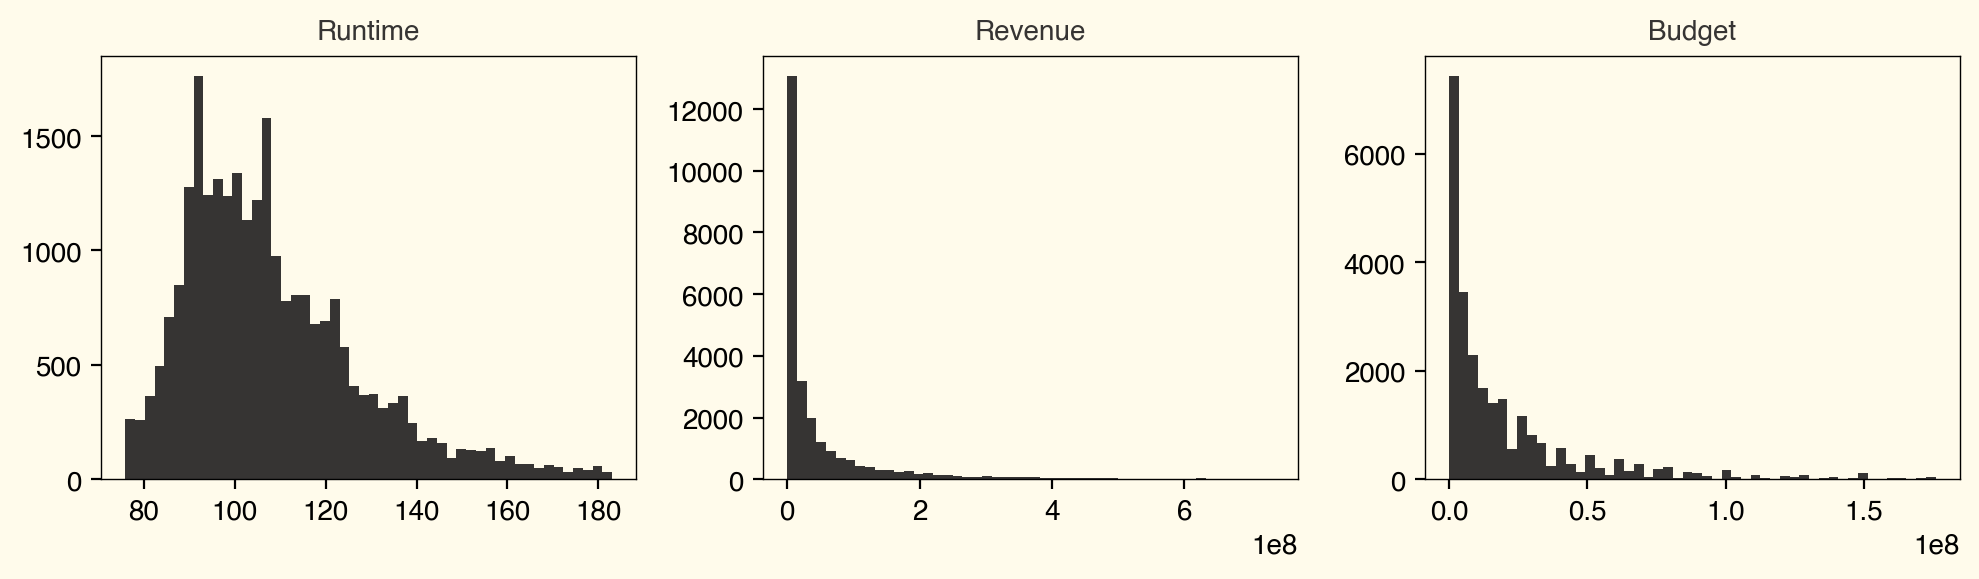

In [7]:
plt.style.use("../assets/plot_styles.mplstyle")

fig, axes = plt.subplots(1, len(colsOfInterest), figsize=(10,3))

# Iterate over the columns of interest and add histograms to subplots
for i, col in enumerate(colsOfInterest):
    # Check the range of the data
    min_val = df[col].min()
    max_val = df[col].max()
    
    # Calculate bin size
    bin_size = (max_val - min_val) / 50  # Example: 20 bins
    
    # Plot histogram
    axes[i].hist(df[col], bins=int((max_val - min_val) / bin_size))
    axes[i].set_title(f"{titleify(col)}")

# Adjust layout
plt.tight_layout()

# Save image
imageFilePath = os.path.join(saveImagePath, 'distributions.png')
plt.savefig(imageFilePath, dpi=300)

# Show the figure
plt.show()


#### Basic linear modelling

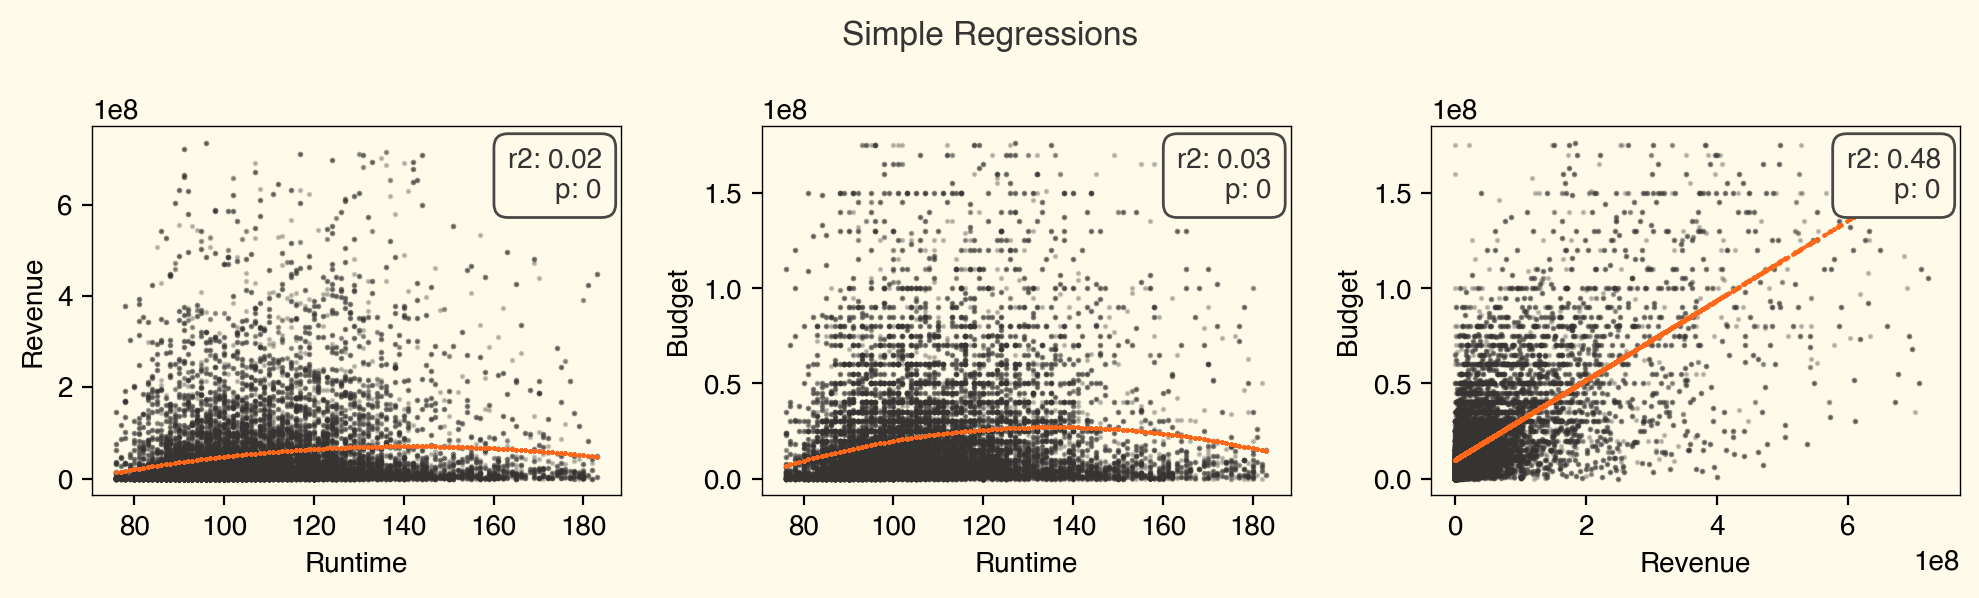

In [11]:
combos = list(itertools.combinations(colsOfInterest, 2))

fig, axes = plt.subplots(1, len(colsOfInterest), figsize=(10,3))
for i, combo in enumerate(combos):
    xVar = combo[0]
    yVar = combo[1]
    
    model = linearModelGeneral(np.array(df[xVar]), np.array(df[yVar]), [1,2])

    axes[i].scatter(df[xVar], df[yVar], s = 1, alpha=.25)
    axes[i].scatter(model['X'], model['ypred'], marker='.', s=1, c=colorPalette['annotation'])
    
    axes[i].set_xlabel(titleify(xVar))
    axes[i].set_ylabel(titleify(yVar))

    annotation_text = f"r2: {round(model['r2'], 2)}\np: {round(model['p'])}"
    axes[i].annotate(annotation_text, xy=(.99, .98), xycoords='axes fraction', fontsize=10,
                    xytext=(-5, -5), textcoords='offset points',
                    ha='right', va='top',
                    bbox=dict(boxstyle='round,pad=0.5', edgecolor=colorPalette['grey_light'], facecolor=colorPalette['canvas']))


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Set title
fig.suptitle('Simple Regressions', fontsize=12)

imageFilePath = os.path.join(saveImagePath, 'simpleRegressions.png')
plt.savefig(imageFilePath, dpi=300)

# Show the figure
plt.show()

### How has runtime been changing over time?

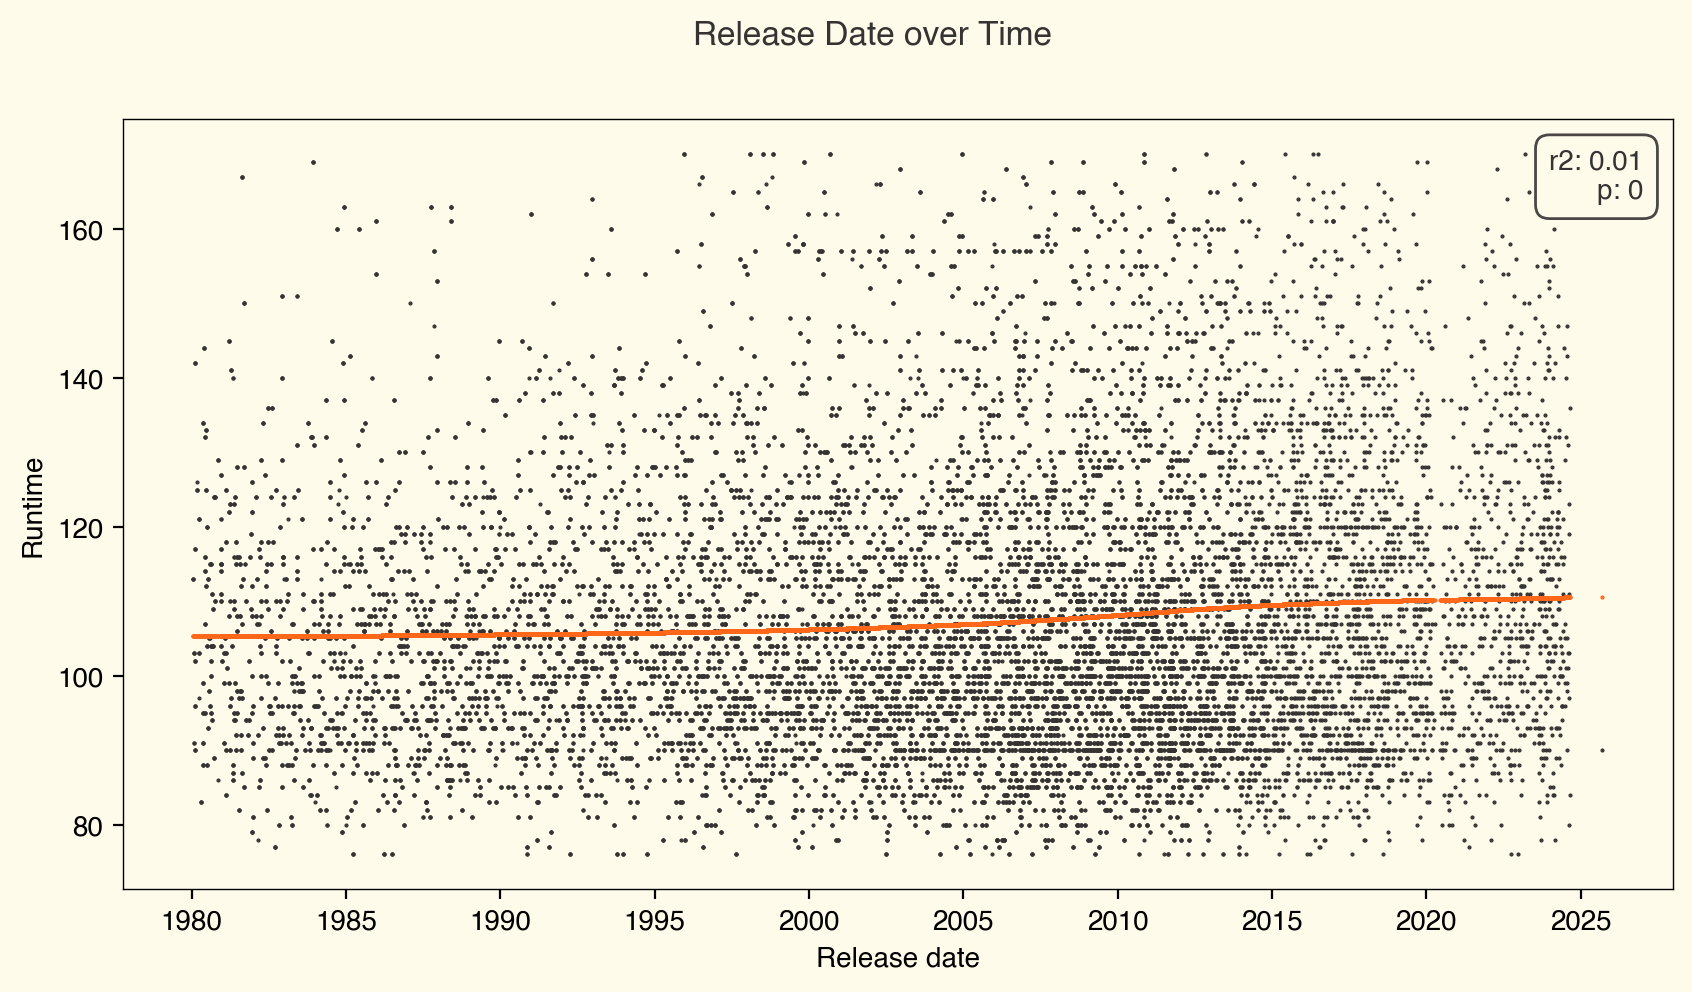

In [21]:
fig, ax = plt.subplots(figsize=(10,5))

df['release_date'] = md.to_datetime(df['release_date'])
df.sort_values(by='release_date', inplace=True, ascending=True)

plotDf = df[df['release_date'] > datetime(1980,1,1)]

xVar = 'release_date'
yVar = 'runtime'

model = linearModelGeneral(X = np.arange(len(plotDf)), y = np.array(plotDf[yVar]), degrees = [1,2])


ax.scatter(plotDf[xVar], plotDf[yVar], marker='.',s=1)
ax.scatter(plotDf[xVar], model['ypred'], marker='.',s=1, c=colorPalette['annotation'])

annotation_text = f"r2: {round(model['r2'], 2)}\np: {round(model['p'])}"
ax.annotate(annotation_text, xy=(.99, .98), xycoords='axes fraction', fontsize=10,
        xytext=(-5, -5), textcoords='offset points',
        ha='right', va='top',
        bbox=dict(boxstyle='round,pad=0.5', edgecolor=colorPalette['grey_light'], facecolor=colorPalette['canvas']))

ax.set_xlabel(titleify(xVar).replace('_', ' '))
ax.set_ylabel(titleify(yVar))

# Set title
fig.suptitle('Release Date over Time', fontsize=12)

imageFilePath = os.path.join(saveImagePath, 'releaseDateRuntime.png')
plt.savefig(imageFilePath, dpi=300)

# Show the figure
plt.show()

In [29]:
model['p']

0.004661674905697248